In [8]:
import kagglehub
import numpy as np
import os
import random

def train_test_split(path, split=0.75, max=None):
    items = [f"{path}/{i}" for i in os.listdir(path) if "png" in i]
    items = items[:max] if max is not None else items
    random.shuffle(items)
    split_index = int(len(items) * split)
    train, test = items[:split_index], items[split_index:]
    return train, test


def csv_loader(path):
    coords = []
    with open(path) as f:
        lines = f.readlines()

    for line in lines:
        lat, lng = line.strip().split(",")
        coords.append([float(lat), float(lng)])

    return coords


# 10,000 images, zero-indexed.png
path = kagglehub.dataset_download("sylshaw/streetview-by-country")
path = kagglehub.dataset_download("paulchambaz/google-street-view")
path = f"{path}/dataset"

coords = csv_loader(f"{path}/coords.csv")

print(f"{len(coords)} coordinates loaded (lat, lng)")

train, test = train_test_split(path, split=0.8)
print(f"{len(train)} images for train, {len(test)} images for test")

# The coordinates for the output-frame (how high resolution should the probability distribution be?)
OUT_H, OUT_W = 32, 64
EPSILON = 1e-12 # value for ensuring model does not hit 0

Resuming download from 96468992 bytes (7837692290 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/sylshaw/streetview-by-country?dataset_version_number=2 (96468992/7934161282) bytes left.


 13%|█▎        | 0.98G/7.39G [03:24<24:39, 4.65MB/s]


KeyboardInterrupt: 

In [2]:
# I call the inputs (incoming nodes) 'x', and outgoing (nodes that I affect) 'o'

class Layer():
    compiled = False
    len = None
    x = None
    o = None
    
    def compile(self, inputs: int = None):
        if self.len is None:
            if inputs is None:
                raise Exception("The layer has an undefined size")
            self.len = inputs
        self.compiled = True
    
    def loss(self, lr):
        pass

    def __len__(self):
        return self.len
        
# ReLU and LeakyReLU together
class ReLU(Layer):
    def __init__(self, c=0):
        self.c = c

    def forward(self, x):
        self.x = x
        self.o = np.where(x > 0, x, self.c * x)
        return self.o
    
    def backward(self, dl):
        return dl * np.where(self.x > 0, 1, self.c)


class Sigmoid(Layer):
    def forward(self, x):
        self.x = x
        self.o = 1 / (1 + np.exp(-x))
        return self.o
    
    def backward(self, dl):
        return dl * self.o * (1 - self.o)


class PatchLinear(Layer):
    def __init__(self, outputs, wpn):
        self.len = outputs
        self.wpn = wpn

    def compile(self, _=None):
        if _ is not None:
            raise Exception("This layer must be the first layer")
            
        self.weights = np.random.randn(self.len, self.wpn) / np.sqrt(self.wpn) # N x Inputs
        self.bias = np.zeros(self.len)  # N x 1
        self.compiled = True

    def forward(self, x):
        self.x = x
        self.o = []
        for patch, weights in zip(x, self.weights):
            self.o.append(patch.T @ weights)  # dot product, returns float
        return np.array(self.o) + self.bias

    def backward(self, dl):
        self.dW = np.zeros_like(self.weights)
        self.db = np.zeros_like(self.bias)
        dx = np.zeros_like(self.x) 

        for i, (patch, w) in enumerate(zip(self.x, self.weights)):
            self.dW[i] = dl[i] * patch
            self.db[i] = dl[i]
            dx[i] = dl[i] * w
        return dx

    def loss(self, lr):
        self.weights -= lr * self.dW
        self.bias -= lr * self.db

    def __repr__(self):
        return f"Patch Linear layer, with {self.wpn} weights per neuron and {self.len} outputs"


class Dense(Layer):
    def __init__(self, outputs):
        self.len = outputs

    def compile(self, inputs):
        if inputs is None and self.inputs is None:
            raise Exception("This layer has an undefined size")
        self.inputs = inputs
        self.weights = np.random.randn(self.len, inputs) / np.sqrt(inputs) # N x Inputs
        self.bias = np.zeros(self.len) # N x 1
        self.compiled = True

    def forward(self, x):
        self.x = x
        self.o = self.weights @ x + self.bias
        return self.o
            
    def backward(self, dl):
        self.dW = np.outer(dl, self.x) # (N) x (Inputs)
        self.db = dl # x 1
        return self.weights.T @ dl
    
    def loss(self, lr):
        self.weights -= lr * self.dW
        self.bias -= lr * self.db

        
    def __repr__(self):
        return f"Dense layer, with {self.inputs} inputs and {self.len} outputs"

class Softmax(Layer):
    def forward(self, x):
        self.x = x
        x_shift = x - np.max(x)
        exp = np.exp(x_shift)
        self.o = exp / np.sum(exp)
        return self.o

    def backward(self, dl):
        return dl # handled in the train loop

In [3]:
from typing import List
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

class Model:
    def __init__(self):
        self.layers: List[Layer] = []

    def sigmoid(self):
        self.layers.append(Sigmoid())
        return self
    
    def relu(self):
        self.layers.append(ReLU())
        return self

    def leaky_relu(self, c: float):
        self.layers.append(ReLU(c=c))
        return self
    
    def patch_linear(self, outputs, wpn):
        self.layers.append(PatchLinear(outputs, wpn))
        return self

    def dense(self, outputs):
        self.layers.append(Dense(outputs))
        return self

    def softmax(self):
        self.layers.append(Softmax())
        return self
    
    def compile(self):
        inputs = None
        for layer in self.layers:
            layer.compile(inputs)
            inputs = len(layer)

    def infer(self, test_gen, test_correct):
        random_index = np.random.randint(0, len(test_correct))
        loss_list = []
        show_inputs, show_target, show_loss, show_source = None, None, None, None
        for index, (source, inputs) in tqdm(enumerate(test_gen()), total=len(test_correct), desc="Testing on novel images:"):
            target = test_correct[index]
            for layer in self.layers:
                inputs = layer.forward(inputs)

            loss = -(target * np.log(inputs + EPSILON)).sum()
            loss_list.append(loss)
            if random_index == index:
                show_source = source
                show_inputs = inputs
                show_target = target
                show_loss = loss

        index = int(show_source.split("/")[-1].split(".")[0])
        show_lat, show_lng = coords[index]
        flat_index = show_inputs.argmax()
        lat_index = flat_index // OUT_W
        lon_index = flat_index % OUT_W 
        guess_lat = ((lat_index + 0.5) / OUT_H) * 180 - 90
        guess_lng = ((lon_index + 0.5) / OUT_W) * 360 - 180

        plt.imshow(show_target.reshape(OUT_H, OUT_W), cmap='hot', origin='lower')
        print(f"MODEL AVERAGE LOSS (NOVEL): {np.mean(loss_list)}")
        print(f"TARGET CORRECT (lat: {show_lat}, lng: {show_lng})")
        plt.title(f"TARGET CORRECT")
        plt.show()
        print(f"MODEL GUESS (guess lat: {guess_lat}, guess lng: {guess_lng})")
        plt.title(f"MODEL GUESS (loss: {show_loss})")
        plt.imshow(show_inputs.reshape(OUT_H, OUT_W), cmap='hot', origin='lower')
        plt.show()
        plt.title(f"REAL IMAGE")
        plt.imshow(Image.open(show_source))
        plt.show()
        plt.hist(loss_list, bins=30)
        plt.xlabel("Loss")
        plt.ylabel("Frequency")
        plt.title("NOVEL IMAGE LOSS HISTOGRAM")
        plt.show()

                
    def train(
        self, 
        train_gen,
        train_correct, 
        test_gen,
        test_correct,
        lr=0.001, 
        epochs=100
    ):
        for epoch in range(epochs):
            loss_list = []

            for index, (source, inputs) in tqdm(enumerate(train_gen()), total=len(train_correct), desc=f"Epoch {epoch + 1}/{epochs}"):
                target = train_correct[index]

                if len(self.layers) == 0:
                    raise Exception("No layers to train")

                if inputs.shape[0] != len(self.layers[0]):
                    raise Exception("Data/input-layer shape mismatch")

                # forward pass
                for layer in self.layers:
                    if not layer.compiled:
                        raise Exception("Please compile your layers!")
                    inputs = layer.forward(inputs)

                if inputs.shape != target.shape:
                    raise Exception("Output-layer/target shape mismatch")

                loss = -(target * np.log(inputs + EPSILON)).sum()
                loss_list.append(loss)
                # backwards pass
                dl = inputs - target
                for index in range(len(self.layers) - 1, -1, -1):
                    layer = self.layers[index]
                    dl = layer.backward(dl)

                # update loss on weights
                for layer in self.layers:
                    layer.loss(lr)

            print(f"Epoch {epoch + 1}/{epochs}; avg loss:", np.mean(loss_list))
            plt.hist(loss_list, bins=60)
            plt.xlabel("Loss")
            plt.ylabel("Frequency")
            plt.title(f"EPOCH {epoch + 1} TRAIN LOSS HISTOGRAM")
            plt.show()
            self.infer(test_gen=test_gen, test_correct=test_correct)
            self.save(f"model_{OUT_H}x{OUT_W}_e{epoch + 1}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.npz")


    def log(self):
        for layer in self.layers:
            print(layer)
    
    def save(self, filepath):
        state = {}
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights') and hasattr(layer, 'bias'):
                state[i] = {'weights': layer.weights, 'bias': layer.bias}
        np.savez(filepath, state=state)
    
    def load(self, filepath):
        data = np.load(filepath, allow_pickle=True)
        state = data['state'].item()
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights') and hasattr(layer, 'bias'):
                layer.weights = state[i]['weights']
                layer.bias = state[i]['bias']

In [4]:
model = (
    Model()
    .patch_linear(400, wpn=3072)  # 20 x 20 patches, 3072 weights per neuron
    .leaky_relu(0.01)
    .dense(640)
    .leaky_relu(0.01)
    .dense(640)
    .leaky_relu(0.01)
    .dense(1200)
    .leaky_relu(0.01)
    .dense(OUT_H * OUT_W) # broadcast back up to heatmap coordinates
    .softmax()
)

model.compile()
model.log()

Patch Linear layer, with 3072 weights per neuron and 400 outputs
Dense layer, with 400 inputs and 640 outputs
Dense layer, with 640 inputs and 640 outputs
Dense layer, with 640 inputs and 1200 outputs
Dense layer, with 1200 inputs and 2048 outputs


In [5]:
def load_imgs(images):
    def gen():
        for img_path in images:
            image = Image.open(img_path)
            yield (img_path, format_frame(np.asarray(image)))
    return gen


def load_correct(images, height, width, sigma=1.0):
    images = [image.split("/")[-1] for image in images]
    indices = [int(image.split(".")[0]) for image in images]
    positions = [coords[index] for index in indices]
    correct = []
    for lat, lng in positions:
        array = np.zeros((height, width))
        lat_index = int((lat + 90) / 180 * height)
        lat_index = min(height - 1, lat_index)
        lon_index = int((lng + 180) / 360 * width)
        lon_index = min(width - 1, lon_index)
        for y in range(height):
            for x in range(width):
                # gaussian distribution for heatmap
                dist = (x - lon_index)**2 + (y - lat_index)**2
                array[y, x] = np.exp(-dist / (2 * sigma**2))
        array = array.flatten()
        normalized = array / array.sum()
        normalized = np.clip(normalized, 1e-12, None)
        normalized = normalized / normalized.sum()
        correct.append(normalized)
    return np.array(correct)

# Need data in the right shape
# Incoming: [640, 640, 3] 
# Returns: -> [3 x 640 x 640]
def format_frame(frame, patch_size=32):
    H, W, C  = frame.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    # this took SO much experimentation, but you need to do this to ensure the patches are preserved
    frame = frame.reshape(num_patches_h, patch_size, num_patches_w, patch_size, 3)
    frame = frame.transpose(0, 2, 1, 3, 4)
    frame = frame.reshape(-1, patch_size, C)
    frame = frame.transpose(2, 0, 1)
    frame = frame.reshape(num_patches_h * num_patches_w, -1)
    return frame / 255.0  # normalize to 0-1


train_image_loader = load_imgs(train)
train_correct = load_correct(train, OUT_H, OUT_W, sigma=2)
test_image_loader = load_imgs(test)
test_correct = load_correct(test, OUT_H, OUT_W, sigma=2)
# model.train(
#     train_gen=train_image_loader, 
#     train_correct=train_correct,
#     test_gen=test_image_loader,
#     test_correct=test_correct,
#     lr=0.01,
#     epochs=80
# )

# model.save(f'model_{OUT_H}x{OUT_W}_e80_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.npz')

Testing on novel images:: 100%|██████████| 8000/8000 [01:00<00:00, 131.65it/s]


MODEL AVERAGE LOSS (NOVEL): 6.738749404609579
TARGET CORRECT (lat: 64.31244851926954, lng: 18.62444218398694)


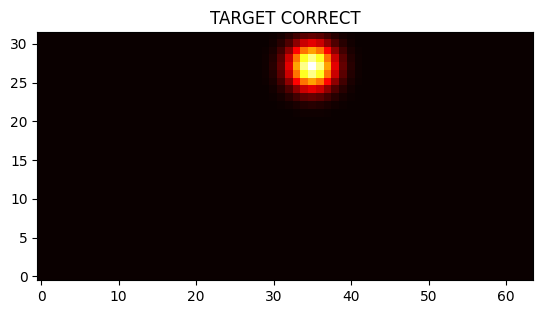

MODEL GUESS (guess lat: 47.8125, guess lng: 25.3125)


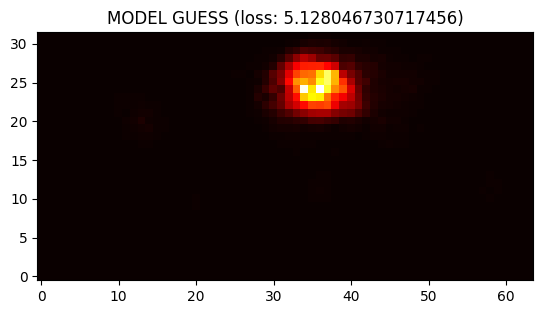

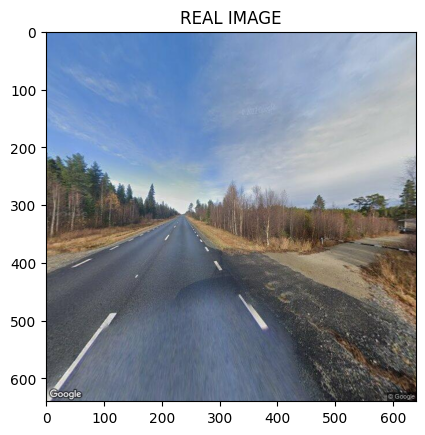

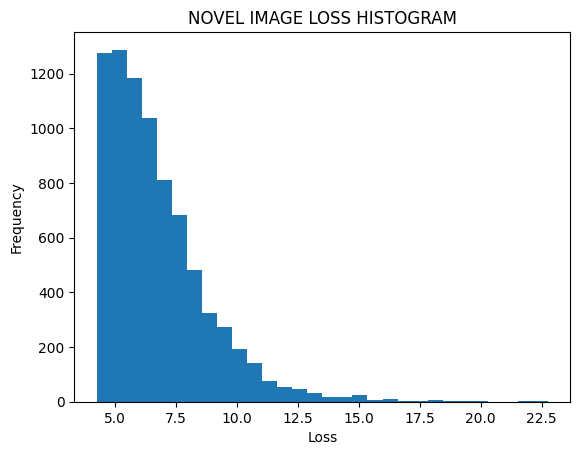

In [ ]:
train_image_loader = load_imgs(train)
train_correct = load_correct(train, OUT_H, OUT_W, sigma=2)
model.load('models/model_32x64_e78_2025-11-21_06-07-44.npz')
model.infer(test_gen=train_image_loader, test_correct=train_correct)